# Bulk Import to Load the Necessary Libraries 

In [3]:
import pymysql
import pandas as pd
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import wikipedia
import spacy
from textblob import TextBlob
from IPython.display import Image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from scipy import sparse
from sklearn.metrics import pairwise_distances

In [4]:

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Project Goal 

The goal of this project is to implement a machine learning model to provide restaurant recommendations to users based on prior reviews and preferences. In the long term the model can be applied to other categories of businesses like 'Hair Salons', 'Coffee Shops' and so on 

# Proposed Methods and Models 

The recommender system is going to be implemented using the following approaches 
1. Collaborative Filtering Mechanism  - Item/Item & User/User 
2. Content Based Filtering Mechanism 
3. Hybrid approach 

# Risk

1. Personally, everything I am doing in this topic is new to me. Hence I am learning as I go 
2. Might need more computing power (either an AWS or some other cloud hosted solution) to run the model
3. Still trying to figure out the best evaluation methods for the recommender system

# Assumption 

There is almost an overload of data. Hence, we will have to parse out some chunks of the dats while building and testing the model 

# Initial Goals

1. Retrieve the data from yelp 
2. Set up a MYSQL instance to load the SQL version of the data 
3. Load the data from MYSQL to Pandas for further analysis 
4. Perform some basic EDA on the important features
5. Build out a simple Collaborative model 
6. Build out a simple Content based model 
7. Using 5 & 6 build out a hydrid model 
8. Test the model for accurancy 

**Stretch Goal:**  Build out a UI for the model in either flask or Tkinter. 


The data for this project is hosted in a MYSQL database. Data is retrieved from MYSQL to a pandas dataframe

# Setting up the connection for MYSQL 

In [5]:
conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='test123', db='mysql')
cur = conn.cursor()

# Loading up the DataFrames from MYSQL

In [6]:
business_df = pd.read_sql('select * from yelp_db.business', con=conn)

In [7]:
user_df = pd.read_sql('select * from yelp_db.user', con=conn)

In [8]:
review_df = pd.read_sql('select * from yelp_db.review', con=conn)

In [9]:
category_df = pd.read_sql('select * from yelp_db.category', con=conn)

In [10]:
attribute_df = pd.read_sql('select * from yelp_db.attribute', con=conn)

In [11]:
checkin_df = pd.read_sql('select * from yelp_db.checkin', con=conn)

In [12]:
tip_df = pd.read_sql('select * from yelp_db.tip', con=conn)

In [13]:
eliteyears_df = pd.read_sql('select * from yelp_db.elite_years', con=conn)

In [14]:
friend_df = pd.read_sql('select * from yelp_db.friend', con=conn)

In [15]:
hours_df = pd.read_sql('select * from yelp_db.hours', con=conn)

In [16]:
photo_df = pd.read_sql('select * from yelp_db.photo', con=conn)

In [17]:
'''Loading from my custom view '''
# user_review_business = pd.read_sql('select * from yelp_db.v_user_revew_business',  con=conn)

'Loading from my custom view '

# Intial Data Validation - Descriptive Analysis

# Business 

In [18]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156639 entries, 0 to 156638
Data columns (total 12 columns):
id              156639 non-null object
name            156639 non-null object
neighborhood    156639 non-null object
address         156639 non-null object
city            156639 non-null object
state           156639 non-null object
postal_code     156639 non-null object
latitude        156638 non-null float64
longitude       156638 non-null float64
stars           156639 non-null float64
review_count    156639 non-null int64
is_open         156639 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 14.3+ MB


In [19]:
business_df.head()

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open
0,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.8409,-79.3996,3.0,30,1
1,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,,16432 Old Statesville Rd,Huntersville,NC,28078,35.4371,-80.8437,4.0,42,1
2,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.3795,-111.7280,4.5,3,1
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,The Strip,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.1232,-115.1690,4.0,1389,1
4,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.3617,-111.9100,3.0,9,1


The business dataframe list the details like business name, business id, address, rating, total number of reviews associated with the business, and the open flag. There are also ~156k business in the dataset

# User

In [20]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183362 entries, 0 to 1183361
Data columns (total 20 columns):
id                    1183362 non-null object
name                  1183362 non-null object
review_count          1183362 non-null int64
yelping_since         1183362 non-null datetime64[ns]
useful                1183362 non-null int64
funny                 1183362 non-null int64
cool                  1183362 non-null int64
fans                  1183362 non-null int64
average_stars         1183362 non-null float64
compliment_hot        1183362 non-null int64
compliment_more       1183362 non-null int64
compliment_profile    1183362 non-null int64
compliment_cute       1183362 non-null int64
compliment_list       1183362 non-null int64
compliment_note       1183362 non-null int64
compliment_plain      1183362 non-null int64
compliment_cool       1183362 non-null int64
compliment_funny      1183362 non-null int64
compliment_writer     1183362 non-null int64
compliment_photos  

In [21]:
user_df.head()

,id,name,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,---1lKK3aKOuomHnwAkAow,Monera,245,2007-06-04,67,22,9,15,3.97,2,3,2,1,0,5,9,9,9,9,0
1,---94vtJ_5o_nikEs6hUjg,Joe,2,2016-05-27,0,0,0,0,5.00,0,0,0,0,0,0,0,0,0,0,0
2,---cu1hq55BP9DWVXXKHZg,Jeb,57,2009-04-18,34,14,0,0,3.79,0,0,0,0,0,3,2,0,0,0,0
3,---fhiwiwBYrvqhpXgcWDQ,Jed,8,2011-04-20,2,3,1,0,2.78,0,0,0,0,0,0,0,0,0,0,0
4,---PLwSf5gKdIoVnyRHgBA,Rae,2,2015-07-31,1,0,0,0,4.00,0,0,0,0,0,0,0,0,0,0,0


The user dataset has attributes like user id, username, total number of reviews submitted by the user along with other user specific attributes. The dataset has close to 1.2 million users in the dataset

# Review

In [22]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736897 entries, 0 to 4736896
Data columns (total 9 columns):
id             object
stars          int64
date           datetime64[ns]
text           object
useful         int64
funny          int64
cool           int64
business_id    object
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 325.3+ MB


In [23]:
review_df.head()

,id,stars,date,text,useful,funny,cool,business_id,user_id
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w
1,---0hl58W-sjVTKi5LghGw,4,2016-07-24,Ate the momos during the momo crawl.. Was the ...,0,0,0,Ae4ABFarGMaI5lk1i98A0w,Y6qylbHq8QJmaCRSlKdIog
2,---3OXpexMp0oAg77xWfYA,5,2012-04-07,Pizza here made my night... Good people and gr...,2,0,0,lKq4Qsz13FDcAVgp49uukQ,SnXZkRN9Yf060pNTk1HMDg
3,---65iIIGzHj96QnOh89EQ,5,2015-09-11,Great brisket sandwich as claimed. Weird that ...,0,0,0,6nKR80xEGHYf2UxAe_Cu_g,VcmSgvslHAhqWoEn16wjjw
4,---7WhU-FtzSUOje87Y4uw,5,2016-01-22,"Interesting food, great atmosphere, and great ...",1,1,1,Z_mJYg3vi8cPZHa1J4BALw,NKF9v-r0jd1p0JVi9h2T1w


This is probably the most important dataset along with users, business as it has most important features needed to build the recommender model. The dataset includes the individual reviews given by the user in terms of the star rating and the text review. The review also has a foreign key to join back to the business and users. The reviews dataset has close to 4.8 reviews across all categories of business

# Category

In [24]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590290 entries, 0 to 590289
Data columns (total 2 columns):
business_id    590290 non-null object
category       590290 non-null object
dtypes: object(2)
memory usage: 9.0+ MB


In [25]:
category_df.head()

,business_id,category
0,YDf95gJZaq05wvo7hTQbbQ,Shopping
1,YDf95gJZaq05wvo7hTQbbQ,Shopping Centers
2,mLwM-h2YhXl2NCgdS84_Bw,Food
3,mLwM-h2YhXl2NCgdS84_Bw,Soul Food
4,mLwM-h2YhXl2NCgdS84_Bw,Convenience Stores


In [28]:
'''Getting the list of Distinct Categories in the Dataset'''

print ('Distinct Category Count: ', len(category_df.category.value_counts()))

Distinct Category Count:  1240


In [30]:
'''Getting the count of businesses listed in each of the top categories'''

category_df.category.value_counts()

Restaurants                        51613
Shopping                           24595
Food                               23014
Beauty & Spas                      15139
Home Services                      13202
Health & Medical                   12033
Nightlife                          11364
Bars                                9868
Automotive                          9476
Local Services                      9343
Event Planning & Services           8038
Active Life                         7427
Fashion                             6299
Sandwiches                          5864
Fast Food                           5792
American (Traditional)              5737
Pizza                               5652
Coffee & Tea                        5565
Hair Salons                         5395
Hotels & Travel                     5188
Arts & Entertainment                5054
Home & Garden                       4584
Auto Repair                         4480
Italian                             4411
Burgers         

This dataset has the business categories. Each business is tied to a category. There are 1240 distinct categories and the most common category is 'Restaurants'.  

In [31]:
'''Top 30 Categories'''
category_df.category.value_counts()[0:30]

Restaurants                  51613
Shopping                     24595
Food                         23014
Beauty & Spas                15139
Home Services                13202
Health & Medical             12033
Nightlife                    11364
Bars                          9868
Automotive                    9476
Local Services                9343
Event Planning & Services     8038
Active Life                   7427
Fashion                       6299
Sandwiches                    5864
Fast Food                     5792
American (Traditional)        5737
Pizza                         5652
Coffee & Tea                  5565
Hair Salons                   5395
Hotels & Travel               5188
Arts & Entertainment          5054
Home & Garden                 4584
Auto Repair                   4480
Italian                       4411
Burgers                       4236
Doctors                       4124
Breakfast & Brunch            4103
Mexican                       3913
Nail Salons         

# Attribute 

In [32]:
attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229805 entries, 0 to 1229804
Data columns (total 3 columns):
business_id    1229805 non-null object
name           1229805 non-null object
value          1229805 non-null object
dtypes: object(3)
memory usage: 28.1+ MB


In [33]:
attribute_df.head()

,business_id,name,value
0,YDf95gJZaq05wvo7hTQbbQ,RestaurantsPriceRange2,2
1,YDf95gJZaq05wvo7hTQbbQ,BusinessParking,"{""garage"": false, ""street"": false, ""validated""..."
2,YDf95gJZaq05wvo7hTQbbQ,BikeParking,1
3,YDf95gJZaq05wvo7hTQbbQ,WheelchairAccessible,1
4,mLwM-h2YhXl2NCgdS84_Bw,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."


The attributes dataset has attributes of the business. 

# Hours 

In [34]:
hours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734421 entries, 0 to 734420
Data columns (total 2 columns):
hours          734421 non-null object
business_id    734421 non-null object
dtypes: object(2)
memory usage: 11.2+ MB


In [35]:
hours_df.head()

,hours,business_id
0,Monday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
1,Tuesday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
2,Friday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
3,Wednesday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
4,Thursday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ


The hours dataet includes hours of operation for the specific business

# Tip

In [36]:
tip_df.head()

,user_id,business_id,text,date,likes
0,zcTZk7OG8ovAmh_fenH21g,tJRDll5yqpZwehenzE2cSg,Get here early enough to have dinner.,2012-07-15,0
1,ZcLKXikTHYOnYt5VYRO5sg,jH19V2I9fIslnNhDzPmdkA,Great breakfast large portions and friendly wa...,2015-08-12,0
2,oaYhjqBbh18ZhU0bpyzSuw,dAa0hB2yrnHzVmsCkN4YvQ,Nice place. Great staff. A fixture in the tow...,2014-06-20,0
3,ulQ8Nyj7jCUR8M83SUMoRQ,dAa0hB2yrnHzVmsCkN4YvQ,Happy hour 5-7 Monday - Friday,2016-10-12,0
4,ulQ8Nyj7jCUR8M83SUMoRQ,ESzO3Av0b1_TzKOiqzbQYQ,"Parking is a premium, keep circling, you will ...",2017-01-28,0


The tips dataet includes some valuable tips from the user on the business 

# Data Model 

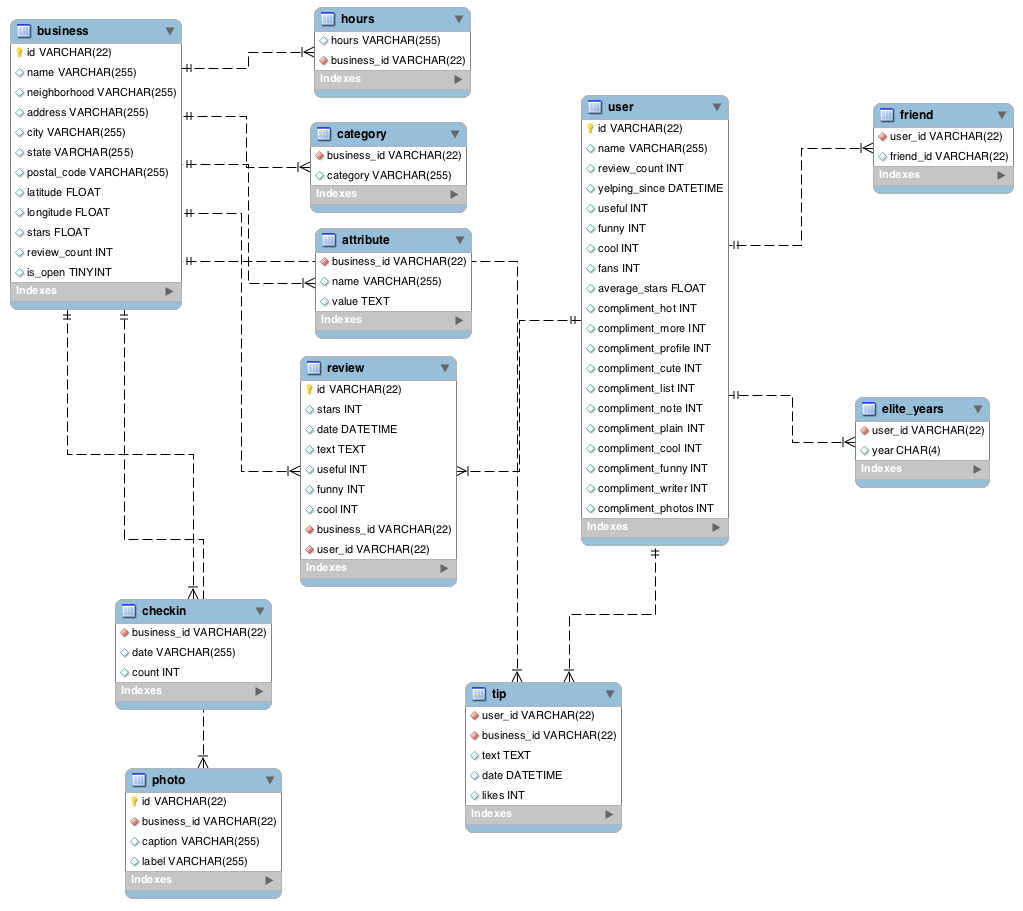

In [37]:
Image("https://s3-media2.fl.yelpcdn.com/assets/srv0/engineering_pages/9c5f7a89fd08/assets/img/dataset/yelp_dataset_schema.png")

Reviews, Users, Business and Categories are the most important datasets for us to build the model

# Data Pre-Processing

The next series of steps will include merging the dataframes to get all the needed elements in one dataframe. The merge will include the following steps 

1. Merging the Reviews and the Business  dataframe 
2. Merging the Users dataframe with the dataframe in step #1. 
3. Merging the categories with the dataframe in step #2. 


## Step 1 Merge: Reviews and Business

### Renaming Columns in the Business Dataframe

In [43]:
'''Renaming the column names in the Business Dataframes before the Merge '''

business_df.rename(columns={'id': 'business_id', 'name': 'business_name', 'address': 'business_address',\
                            'city': 'business_city', 'state': 'business_state',\
                            'postal_code': 'business_postal_code' , 'stars': 'business_stars',\
                            'review_count': 'business_review_count', 'is_open': 'business_isopen'}, inplace=True)

In [44]:
'''Reviewing the list of column names in the Business Dataframe'''

business_df.columns

Index(['business_id', 'business_name', 'neighborhood', 'business_address', 'business_city', 'business_state', 'business_postal_code', 'latitude', 'longitude', 'business_stars', 'business_review_count', 'business_isopen'], dtype='object')

### Renaming Columns in the Review Dataframe

In [45]:
'''Renaming the column names in the Review Dataframes before the Merge '''

review_df.rename(columns={'id': 'review_id', 'stars': 'review_stars', 'date': 'review_date',\
                          'text': 'review_text', 'useful': 'review_useful', 'funny': 'review_funny',\
                          'cool': 'review_cool'}, inplace = True)

In [46]:
'''Reviewing the list of columns in the Review Dataframe'''

review_df.columns

Index(['review_id', 'review_stars', 'review_date', 'review_text', 'review_useful', 'review_funny', 'review_cool', 'business_id', 'user_id'], dtype='object')

In [ ]:
review_business = pd.merge(review_df, business_df, on='business_id' )

In [ ]:
review_business.head()

In [ ]:
print ('Shape of Review Dataframe: ',  review_df.shape)

print ('Shape of Business Dataframe: ',  business_df.shape)

print ('Shape of Review Business Dataframe: ',  review_business.shape)

We are able to confirm that the number of rows in the original reviews dataframe and the merged reviews dataframe is the same.

## Step 2 Merge: Review, Business and Users 

### Renaming the columns in the Users Dataframe

In [ ]:
user_df.rename(columns={'id': 'user_id', 'name': 'user_name', 'review_count': 'user_review_count',\
                       'yelping_since': 'user_yelping_since'}, inplace=True)

In [ ]:
user_df_short = user_df[['user_id', 'user_name', 'user_review_count', 'user_yelping_since']]
# user_df_short['user_id_name'] = user_df_short['user_name'] + user_df_short['user_id']
user_df_short.head()

In [ ]:
review_business_users = pd.merge(review_business, user_df_short, on= 'user_id')

In [ ]:
review_business_users.head()

In [ ]:
review_business_users.info()

In [ ]:
print ('Shape of Review Dataframe: ',  review_df.shape)

print ('Shape of Business Dataframe: ',  business_df.shape)

print ('Shape of Users Dataframe: ', user_df.shape)

print ('Shape of Review Business Users Dataframe: ',  review_business_users.shape)

The number of rows in the original reviews dataframe is the same as the number of rows in the merged reviews dataframe

### Renaming the columns in the Categories Dataframe 

In [454]:
category_df.rename(columns={'category': 'category_name'}, inplace=True)

In [455]:
'''Extracting the list of Restaurant Categories only'''
restaurant_category = category_df.loc[category_df['category_name'] == 'Restaurants',:]

In [456]:
restaurant_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51613 entries, 5 to 590279
Data columns (total 2 columns):
business_id      51613 non-null object
category_name    51613 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


In [457]:
restaurant_category.head()

,business_id,category_name
5,mLwM-h2YhXl2NCgdS84_Bw,Restaurants
11,duHFBe87uNSXImQmvBh87Q,Restaurants
54,SDMRxmcKPNt1AHPBKqO64Q,Restaurants
59,iFEiMJoEqyB9O8OUNSdLzA,Restaurants
76,HmI9nhgOkrXlUr6KZGZZew,Restaurants


In [452]:
# restaurant_category.drop_duplicates('business_id', keep='first', inplace=True)

In [453]:
# restaurant_category.info()

## Step 3 Merge: Review, Business, Users and Categories 

In [534]:
review_business_users_category = pd.merge(review_business_users, restaurant_category, on = 'business_id')

In [233]:
review_business_users_category.head()

In [234]:
'''Reviewing the final set of columns that is in our merged dataframe'''
# review_business_users_category.columns

'Reviewing the final set of columns that is in our merged dataframe'

On quick review we notice a few important columns like review_stars, user_name, business_name, business_state, business_city.  

### Performing some quick EDA to see the list of States in the dataset 

In [235]:
# review_business_users_category['business_state'].value_counts()

# Extracting the Restaurants in the state of WI

For the purposes of building out the initial model we are going to extract out the restaurants in the state of Wisconsin alone. i.e. (business_state == 'WI') 

In [236]:
# review_wi = review_business_users_category.loc[review_business_users_category['business_state']  == 'WI', :]
# review_wi = review_business_users_category.loc[review_business_users_category['business_state']  == 'SC', :]

review_wi = review_business_users.loc[review_business_users['business_state']  == 'SC', :]

#### Reviewing the number of restaurants in the WI area

In [237]:
'''Validating the number of restaurants in the WI area'''
print ('Total Number of Restaurants in the selected Dataset: ', len(review_wi.business_name.unique()))

Total Number of Restaurants in the selected Dataset:  525


In [238]:
'''List of 100 Restaurants in the selected Dataset'''
list(review_wi.business_name.unique())[0:100]

['QuikTrip',
 'Walmart Supercenter',
 'The Flipside Cafe',
 'Lee Cafe',
 'Hwy 55 Burgers Shakes & Fries',
 'Springs Farm Market',
 "Di-Dee's Diner",
 "Madison's On the Corner",
 "Miller's Produce",
 'Fish Market',
 'Cupcrazed Cakery',
 'The Peach Stand',
 'Mamas Pizza & Pasta',
 "Rizzo's Spaghetti House",
 'Hickory Tavern',
 "Brew's Tavern",
 '521 BBQ & Grill',
 'Six Pence Pub',
 "Salsarita's Fresh Mexican Grill",
 'Fort Mill Hyundai',
 'Freebirds Family Restaurant',
 'Akahana - Asian Bistro, Bar & Sushi',
 'Tapas 51',
 'Veterinary Medical Center of Fort Mill',
 'Blacow Burger',
 'Passion8 Bistro',
 'Grapevine',
 'Southern Spirits',
 "Culver's",
 'South Carolina Strawberry Festival',
 'Xplore Scuba',
 "Papa Pino's",
 'Blue Wave Stable',
 'Anne Springs Close Greenway',
 'Famous Toastery',
 'Local Dish',
 "Hobo's",
 'Fort Mill BBQ Company',
 'Starbucks',
 "Zaxby's Chicken Fingers & Buffalo Wings",
 'Pucker Butt Pepper Company',
 'Fort Mill Post Office',
 'Subway',
 "Hardee's of Fort Mill

### Reviewing the list of reviews in the dataset 

In [239]:
'''Validating the number of reviews'''
print ('Total Number of reviews in the selected Dataset: ', len(review_wi.review_id.unique()))

Total Number of reviews in the selected Dataset:  9393


Now that we have the data in a decent shape and form, we can start of by building out a simple model. One of the simpler models with recommender systems is the collaborative filtering model.

# Creating the Sparse Matrix for Collaborative Filtering

In [256]:
sparse_m = review_wi.pivot_table(index='user_id', columns='business_name', values='review_stars')

In [257]:
'''Replacing the spaces in the column names with the _'''
sparse_m.columns = sparse_m.columns.str.replace(' ', '_')
sparse_m.columns = sparse_m.columns.str.replace("'", '-')
sparse_m.columns = sparse_m.columns.str.replace(",", '-')

In [258]:
sparse_m.head(20)

business_name,24_Hour_Rapid_Locksmith,521_BBQ_&_Grill,7-Eleven,9Round,A_Happier_Dog,ANu_Wave_Auto_Care,Above_Board_Games,Adecco,Advance_Auto_Parts,Akahana_-_Asian_Bistro-_Bar_&_Sushi,...,Willow_Tree_Massage_Therapy,Wing_King_Cafe,WingBonz,Wireless_Medics_-_Fort_Mill,Xplore_Scuba,Young_Plantations,Z_Bakery,Zaxby-s_Chicken_Fingers_&_Buffalo_Wings,iColor_Nail_Bar,iRejuvenate
user_id,,,,,,,,,,,,,,,,,,,,,
--44NNdtngXMzsxyN7ju6Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--RNUEvgFSw-b-hhhgZzSg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0b84SUGVN0YkG5j2MCmBw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1FEXqwQSerk4L7Vrdodgg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1it-1oll1OOP6KMsF-Auw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2ANswl5B5huLP9AOc21ZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2eA6kf1uQ1_B4I44O8SAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2y-NzBqY0GoHYvI_DEO6Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2ygE51TlRy87YVu4sUv-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
sparse_m.shape

(5278, 525)

In [260]:
sparse_m.fillna(0, inplace=True)
sparse_m.head()

business_name,24_Hour_Rapid_Locksmith,521_BBQ_&_Grill,7-Eleven,9Round,A_Happier_Dog,ANu_Wave_Auto_Care,Above_Board_Games,Adecco,Advance_Auto_Parts,Akahana_-_Asian_Bistro-_Bar_&_Sushi,...,Willow_Tree_Massage_Therapy,Wing_King_Cafe,WingBonz,Wireless_Medics_-_Fort_Mill,Xplore_Scuba,Young_Plantations,Z_Bakery,Zaxby-s_Chicken_Fingers_&_Buffalo_Wings,iColor_Nail_Bar,iRejuvenate
user_id,,,,,,,,,,,,,,,,,,,,,
--44NNdtngXMzsxyN7ju6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--RNUEvgFSw-b-hhhgZzSg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0b84SUGVN0YkG5j2MCmBw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1FEXqwQSerk4L7Vrdodgg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1it-1oll1OOP6KMsF-Auw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [261]:
'''Top 20 Most Recommended Business'''
sparse_m.sum().sort_values(ascending=False)[0:20]

business_name
The_Flipside_Cafe                      1308.0
Local_Dish                             1045.0
521_BBQ_&_Grill                         777.5
Cupcrazed_Cakery                        690.0
Famous_Toastery                         638.5
Hobo-s                                  629.0
Captain_Steve-s                         603.0
Lee_Cafe                                460.0
Fish_Market                             407.0
Blacow_Burger                           402.0
Tapas_51                                342.0
Peking_Tokyo                            342.0
Akahana_-_Asian_Bistro-_Bar_&_Sushi     334.0
T-Bones_On_the_Lake                     332.0
Danny-s_Pizza_and_Pasta                 329.0
Six_Pence_Pub                           324.0
Culver-s                                315.0
Red_Bowl                                287.0
Sweetwater_Sports_Bar_&_Grill           274.0
Marin_Door_To_Door                      272.0
dtype: float64

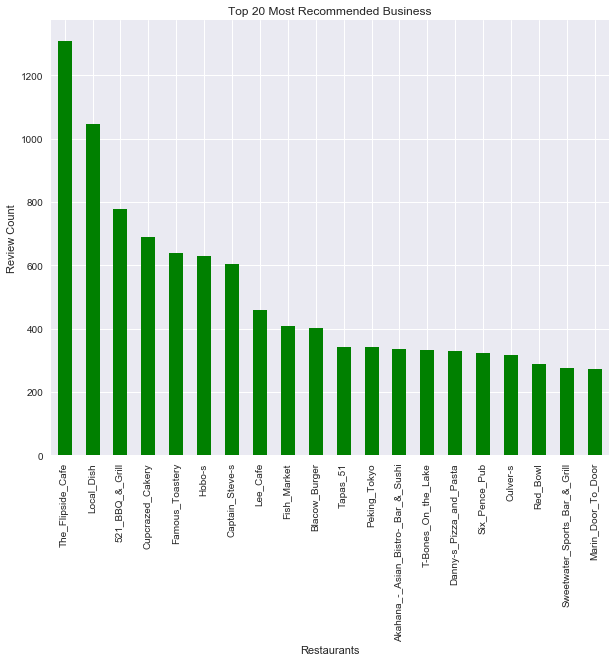

In [262]:
'''Top 20 Most Recommended Restaurants'''
sparse_m.sum().sort_values(ascending=False)[0:20].plot(kind='bar', color='g', figsize = (10,8))
plt.title('Top 20 Most Recommended Business')
plt.xlabel('Restaurants')
plt.ylabel('Review Count')

# Model Building

# Collaborative Filtering Model

#### Setting up the inputs for the model 

In [458]:
sparse_m.index

Index(['--44NNdtngXMzsxyN7ju6Q', '--RNUEvgFSw-b-hhhgZzSg', '-0b84SUGVN0YkG5j2MCmBw', '-1FEXqwQSerk4L7Vrdodgg', '-1it-1oll1OOP6KMsF-Auw', '-2ANswl5B5huLP9AOc21ZA', '-2eA6kf1uQ1_B4I44O8SAQ', '-2y-NzBqY0GoHYvI_DEO6Q', '-2ygE51TlRy87YVu4sUv-A', '-3WF6NuAI-FoCjpTdufclQ',
       ...
       'ztGtoOtbK4DRtzzrlxWvoQ', 'ztcNHvleigpjR6snP7a8sw', 'zuKQYycy74OJEUAKIWcTdw', 'zvFeFboNMXqes2x5yqxpYw', 'zwpWND0CXwyVq1P7sjoMcw', 'zx2mMtOoJTULgj2gTMiJZA', 'zxjdko2tNOxCpvKQq4oRJg', 'zyK_lHnOYAZFUY2I9Q7YjA', 'zza-gQ2jzjAAJkalUHuO6Q', 'zzg3bpldFxSyDJ4s1nMNvw'], dtype='object', name='user_id', length=5278)

In [459]:
restaurants_df = sparse_m

In [460]:
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5278 entries, --44NNdtngXMzsxyN7ju6Q to zzg3bpldFxSyDJ4s1nMNvw
Columns: 525 entries, 24_Hour_Rapid_Locksmith to iRejuvenate
dtypes: float64(525)
memory usage: 21.3+ MB


In [461]:
restaurants_df.tail(1000)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [547]:
user = 'hgWmZXmxG90Zt7Hm0OWqKQ'
# user='zwpWND0CXwyVq1P7sjoMcw'

### Item Item Collaborative Filtering 

# Predictor Function: Item-Item Predictor

In [520]:
# Backing up this code: 

# '''Collaborative Item-Item filtering function to make predictions'''

# def rating_predictor_colab_ii_all():
    
#     predicted_rating_dict = {}
    
# #     user_rated = user_rated_list(user)
# #     user_not_rated = user_not_rated_list(user)
     
#     co_occurence_matrix = cooccurence_matrix_creator()
#     restaurants_to_rate = rest_to_rate(co_occurence_matrix)
    
#     for not_rated in restaurants_to_rate.columns: 
#         column_df = pd.DataFrame(restaurants_to_rate[not_rated].sort_values(ascending=False))
#         predicted_rating = []
#         top_sim_list = []
#         if column_df.shape[0] == 1: 
#             top_sim = column_df[not_rated]
            
#             top_sim_list.append(top_sim)

#             given_rr = column_df[not_rated].index
            
#             given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
#             given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

#             adjusted_predicted_rating = float(given_rank*top_sim)
#             predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
#         else: 
#             for top_n in range(co_occurence_matrix.shape[0]):   

#                 top_sim = column_df[not_rated][top_n]
#                 top_sim_list.append(top_sim)

#                 given_rr = column_df[not_rated].index[top_n]
                
#                 given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
#                 given_rank = given_rank_df.loc[given_rr,:]

#                 predicted_rating_item = float(given_rank*top_sim)
#                 predicted_rating.append(predicted_rating_item)
#             total_sim_weight = sum(top_sim_list)
#             adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
#             predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
#     '''Creating the Dataframe in this step'''
        
#     predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
#     predicted_df.fillna(0, inplace=True)
#     predicted_df.columns=[user]
#     predicted_df.sort_values([user], ascending=False, inplace=True)
#     return predicted_df


# Helper Functions for Item-Item Collaborative Filtering

In [571]:


'''Function to return the list of restaurants rated by the user'''
def user_rated_list(user):
    user_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == False:
            user_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return user_rated  


'''Function to return the list of restaurants yet to be rated by the user'''
def user_not_rated_list(user):
    user_not_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == True:
            user_not_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return (user_not_rated) 


'''Function to calculate the Co-Similarity'''
def cosim(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)


'''Function to calculate the co-sine similarity between the restaurants rated by the user and all the restaurants in the list'''
def cooccurence_matrix_creator():
    '''Calling the user rated function'''
    user_rated = user_rated_list(user)
    ur_rest_dict = {}
    for ur in user_rated: 
        ur_cosim=[]
        for ar in list(restaurants_df.columns): 
            similarity = cosim(restaurants_df[ur],\
                                            restaurants_df[ar])
            ur_cosim.append(similarity)
        ur_rest_dict[ur] = ur_cosim
    co_occurence_matrix = pd.DataFrame.from_dict(ur_rest_dict, orient='index')
    co_occurence_matrix.columns=list(restaurants_df.columns)
    return co_occurence_matrix

'''Function to create dataframe of the restaurants to be rated'''
def rest_to_rate(df):
    restaurants_to_rate = df[user_not_rated_list(user)]
    return restaurants_to_rate

In [559]:
'''Bugs Fixed in the main dataset run

1. Added condition to handle users who have rated only one restaurant. This was resulting in an index out of bound error.
2. Added logic to handle users who have rated multiple restaurants but the coocurence is non-zero for only on restaurant. 
3. Added logic to handle 
''' 

'''Collaborative Item-Item filtering function to make predictions'''

def rating_predictor_colab_ii_all():
    
    predicted_rating_dict = {}
    
#     user_rated = user_rated_list(user)
#     user_not_rated = user_not_rated_list(user)
     
    co_occurence_matrix = cooccurence_matrix_creator()
    restaurants_to_rate = rest_to_rate(co_occurence_matrix)
    
    for not_rated in restaurants_to_rate.columns: 
        column_df = pd.DataFrame(restaurants_to_rate[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        if column_df.shape[0] == 1: 
            top_sim = column_df[not_rated]            
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index
            
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
            given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

            adjusted_predicted_rating = float(given_rank*top_sim)
            predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
        else: 
            for top_n in range(co_occurence_matrix.shape[0]):   

                top_sim = column_df[not_rated][top_n]
                
                '''Added for bug fix'''
                if top_sim == 0: 
                    continue 
                else:
                    top_sim_list.append(top_sim)

                    given_rr = column_df[not_rated].index[top_n]

                    given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
                    given_rank = given_rank_df.loc[given_rr,:]

                    predicted_rating_item = float(given_rank*top_sim)
                    predicted_rating.append(predicted_rating_item)
            
            if len(top_sim_list) == 1: 
                predicted_rating_dict[not_rated] = predicted_rating_item
            
            else: 

                total_sim_weight = sum(top_sim_list)
#                 print ('Total_sim_weight:', total_sim_weight)
                
                if total_sim_weight == 0: 
                    predicted_rating_dict[not_rated] = 0 
                else:
                    adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
                    predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
        
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.fillna(0, inplace=True)
    predicted_df.columns=[user]
    predicted_df.sort_values([user], ascending=False, inplace=True)
    return predicted_df


In [566]:
'''Calling the predictor to make predictions'''
predicted_df = rating_predictor_colab_ii_all()
predicted_df.head()

,hgWmZXmxG90Zt7Hm0OWqKQ
WingBonz,4.809140
Hickory_Tavern,4.782209
Hwy_55_Burgers_Shakes_&_Fries,4.767646
Shane-s_Rib_Shack,4.751106
Jim_-N_Nick-s_Bar-B-Q,4.707208


In [570]:
predicted_df[predicted_df.index=='Wags_&_Whiskers']

,hgWmZXmxG90Zt7Hm0OWqKQ
Wags_&_Whiskers,0.128113


# Testing some pseudocode here - For Item-Item filtering model

In [562]:
user_rated_list(user)

['521_BBQ_&_Grill', 'Akahana_-_Asian_Bistro-_Bar_&_Sushi', 'Burger_Craft']

In [563]:
coc = cooccurence_matrix_creator()
coc

,24_Hour_Rapid_Locksmith,521_BBQ_&_Grill,7-Eleven,9Round,A_Happier_Dog,ANu_Wave_Auto_Care,Above_Board_Games,Adecco,Advance_Auto_Parts,Akahana_-_Asian_Bistro-_Bar_&_Sushi,Aldi,All_Paws_Grooming,Allstate_Insurance_Agent:_Corey_Hinson_&_Associates,Alternative_Tan_of_Tega_Cay,America-s_Mattress,American_Cafe_&_Lounge,Anchor_Self_Storage-Lake_Wylie,Angelos_of_Fort_Mill,Anne_Springs_Close_Greenway,Anytime_Fitness,Arby-s,Arce_Heating_and_AC,Archie_Boy-s_BBQ,Aroma_Coffee_House,Asian_Express,Asian_Roll_&_Grill,Autobell_Car_Wash,BP,Bacintyme_Coffee_Cafe,Bagel_Boat,Balance_Yoga_and_Massage,Ballantyne_And_Beyond_Moving,Barnyard_Flea_Market,Bavarian_Deli,Baxter_Barber_Shop,Baxter_Beauty_Bar,Baxter_Nails_and_Spa,Baxter_Social_House,Baxter_Veterinary_Clinic,Baxter_Village,Baxter_Village_Imaging_Center,Baxter-s_Bunch_Playhouse,Beautiful_Nails_&_Spa,Beef_-O-_Brady-s,Beertopia,Belle_Vive_Spa_&_Wellness_Centre,Bert-s_Backyard_Bar_and_Bistro,Best_China,Best_Western_Carowinds,Beyond_Measure_Salon_and_Spa,Bi-Lo,Biehl_Brian_L_DMD,Big_Apple_Bagels,Big_Wok,Birds_of_A_Feather,Bistro_160_Cafe_&_Catering,Blacow_Burger,Blessed_Hands_Massage,Bloom_Beauty_Bar,Blue_Heron_Grill,Blue_Rose_Pottery,Blue_Wave_Stable,Bojangles,Bojangles_Restaurant,Bojangles-_Famous_Chicken_-n_Biscuits,Bowzee_Wowzee_Pet_Boarding,Bravo_Antonio,Bravo_Restaurant,Breadsmith,Brew-s_Tavern,Brian_Horine_-_State_Farm_Insurance_Agent,Brixx_Wood_Fired_Pizza,Bromley,Brothers-_Auto_Tech,Bruster-s_Real_Ice_Cream,Bubbles_N-_Bows_Doggie_Salon,Bubbly_Nails,Burger_Craft,Burger_King,Burn_Boot_Camp,Buy_the_Bunch,Cabela-s,Camp_Bow_Wow_Fort_Mill,Captain_Steve-s,Carlos_Cafe,Carmellas_Pizza_Grill,Carolina_Ale_House,Carolina_Country_Store,Carolina_Creamery,Carolina_E-Cigs,Carolina_Family_Dentistry_At_Lake_Wylie-_PLLC,Carolina_Fitness_Rentals,Carolina_Lakes_Golf_Club,Carolina_Orthopaedic_Surgery_Associates_PA,Carolina_Place_Animal_Hospital,Carolina_Podiatry_Group,Carolina_Smile_Dentistry,Carolina_Sports_Clinic,Carolina_Upholstery,Carolina_Wines_&_Spirits,Carolinas_Cornerstone_Church,Casa_Colombia,Casual_Water,Catawba_River_Dentistry,Century_Springfield_Meadows_Apartments,Charanda_Mexican_Grill_&_Cantina,Charlotte_/_Fort_Mill_KOA,Charlotte_Knights_Baseball,Charlotte_Matchmakers,Cherry,Cherry_Sushi_&_Grill,Cheryl_Fleming_Photography,Chick-fil-A,China_East,China_II,China_Inn,Chinatown,ChocolatBoutique,Christian_Brothers_Automotive_Tega_Cay,Circa_North_Salon,Circle_K,City_Tavern,Clarion_Hotel_At_Carowinds,Classic_Cleaners_2,Classic_Salon_Nails_&_Spa,Classy_Nails,ClayEscape_LLC,Clearwater_Pool_Service,Clipper_Doodles,Cloud_9_Martini_&_Tapas_Bar,Coco_Pilates_&_BodyWorks,Comfort_Inn_At_Carowinds,Comporium,Comporium_Communications,Cracker_Barrel_Old_Country_Store,CrossRidge_Cafe,Crossfit_S3,Crown_Cove_RV_Park,Crown_Plaza_Chiropractic,Cruzin_Reubenz_by_Phil-s_Deli,Culver-s,Cupcrazed_Cakery,Curtsinger_Animal_Hospital,Cvs_Pharmacy,Dairy_Queen,Danny-s_Pizza,Danny-s_Pizza_and_Pasta,Darrell-s_Auto_&_Body_Shop,Dave-s_Comics,Davey_Jones_Fireworks,De_Marco-s_Italian_Grill,Del_Webb_Library,DentalWorks,Di-Dee-s_Diner,Diana-s_Blinds_&_Designs,Digby-s_Pizza,Dirty_Dog_Depot,Dirty_Martini,Discount_Tire_Store_-_Fort_Mill-_SC,Discount_Tire_Store_-_Indian_Land-_SC,Dolce_Lusso,Dominguez_&_Rucker_Family_Dentistry,Domino-s_Pizza,Drunken_Goat_Bar_&_Grill,Dunkin-_Donuts,E&J-s_Pit_Beef,Eat_Well,Econo_Lodge_at_Carowinds,El_Cancun_Mexican_Restaurant,El_Maguey,Empire_Pizza_&_Bar,Enterprise_Rent-A-Car,Esalerugs,Esposito-s_Pizzeria_Bagels,Express_Oil_Change,Exxon_Gas_Station,Fairway_Fuel,Famous_Toastery,Fast_Growing_Trees,Fendi_Nails,Figaro-s_Pizza,Firestone_Complete_Auto_Care,Fish_Market,Five_Star_Nail_and_Spa,Flat_Rate_Movers,Fleet_Feet,Food_Lion,Fort_Mill_Animal_Clinic,Fort_Mill_Auto_Service_&_Fleet,Fort_Mill_Automotive,Fort_Mill_BBQ_Company,Fort_Mill_Branch_YMCA,Fort_Mill_Dermatology,Fort_Mill_Family_Practice,Fort_Mill_Family_Restaurant,Fort_Mill_Ford,Fort_Mill_Golf_Club,Fort_Mill_Hyundai,Fort_Mill_Pharmacy,Fort_Mill_Post_Office,Fort_Mill

In [565]:
coc[['Wags_&_Whiskers','Miller-s_Produce', 'WingBonz', 'Casa_Colombia', 'Hickory_Tavern']]

,Wags_&_Whiskers,Miller-s_Produce,WingBonz,Casa_Colombia,Hickory_Tavern
521_BBQ_&_Grill,0.025623,0.013889,0.059876,0.055170,0.100163
Akahana_-_Asian_Bistro-_Bar_&_Sushi,0.000000,0.000000,0.000000,0.015152,0.012240
Burger_Craft,0.000000,0.000000,0.004068,0.000000,0.000000


In [533]:
specific_user = restaurants_df[restaurants_df.index=='hgWmZXmxG90Zt7Hm0OWqKQ']
specific_user[user_rated_list(user)]

business_name,521_BBQ_&_Grill,Akahana_-_Asian_Bistro-_Bar_&_Sushi,Burger_Craft
user_id,,,
hgWmZXmxG90Zt7Hm0OWqKQ,5.0,3.0,2.0


In [551]:
restaurants_to_rate.head()

,24_Hour_Rapid_Locksmith,521_BBQ_&_Grill,7-Eleven,9Round,A_Happier_Dog,ANu_Wave_Auto_Care,Above_Board_Games,Adecco,Advance_Auto_Parts,Akahana_-_Asian_Bistro-_Bar_&_Sushi,Aldi,All_Paws_Grooming,Allstate_Insurance_Agent:_Corey_Hinson_&_Associates,Alternative_Tan_of_Tega_Cay,America-s_Mattress,American_Cafe_&_Lounge,Anchor_Self_Storage-Lake_Wylie,Angelos_of_Fort_Mill,Anne_Springs_Close_Greenway,Anytime_Fitness,Arby-s,Arce_Heating_and_AC,Archie_Boy-s_BBQ,Aroma_Coffee_House,Asian_Express,Asian_Roll_&_Grill,Autobell_Car_Wash,BP,Bacintyme_Coffee_Cafe,Bagel_Boat,Balance_Yoga_and_Massage,Ballantyne_And_Beyond_Moving,Barnyard_Flea_Market,Bavarian_Deli,Baxter_Barber_Shop,Baxter_Beauty_Bar,Baxter_Nails_and_Spa,Baxter_Social_House,Baxter_Veterinary_Clinic,Baxter_Village,Baxter_Village_Imaging_Center,Baxter-s_Bunch_Playhouse,Beautiful_Nails_&_Spa,Beef_-O-_Brady-s,Beertopia,Belle_Vive_Spa_&_Wellness_Centre,Bert-s_Backyard_Bar_and_Bistro,Best_China,Best_Western_Carowinds,Beyond_Measure_Salon_and_Spa,Bi-Lo,Biehl_Brian_L_DMD,Big_Apple_Bagels,Big_Wok,Birds_of_A_Feather,Bistro_160_Cafe_&_Catering,Blacow_Burger,Blessed_Hands_Massage,Bloom_Beauty_Bar,Blue_Heron_Grill,Blue_Rose_Pottery,Blue_Wave_Stable,Bojangles,Bojangles_Restaurant,Bojangles-_Famous_Chicken_-n_Biscuits,Bowzee_Wowzee_Pet_Boarding,Bravo_Antonio,Bravo_Restaurant,Breadsmith,Brew-s_Tavern,Brian_Horine_-_State_Farm_Insurance_Agent,Brixx_Wood_Fired_Pizza,Bromley,Brothers-_Auto_Tech,Bruster-s_Real_Ice_Cream,Bubbles_N-_Bows_Doggie_Salon,Bubbly_Nails,Burger_Craft,Burger_King,Burn_Boot_Camp,Buy_the_Bunch,Cabela-s,Camp_Bow_Wow_Fort_Mill,Captain_Steve-s,Carlos_Cafe,Carmellas_Pizza_Grill,Carolina_Ale_House,Carolina_Country_Store,Carolina_Creamery,Carolina_E-Cigs,Carolina_Family_Dentistry_At_Lake_Wylie-_PLLC,Carolina_Fitness_Rentals,Carolina_Lakes_Golf_Club,Carolina_Orthopaedic_Surgery_Associates_PA,Carolina_Place_Animal_Hospital,Carolina_Podiatry_Group,Carolina_Smile_Dentistry,Carolina_Sports_Clinic,Carolina_Upholstery,Carolina_Wines_&_Spirits,Carolinas_Cornerstone_Church,Casa_Colombia,Casual_Water,Catawba_River_Dentistry,Century_Springfield_Meadows_Apartments,Charanda_Mexican_Grill_&_Cantina,Charlotte_/_Fort_Mill_KOA,Charlotte_Knights_Baseball,Charlotte_Matchmakers,Cherry,Cherry_Sushi_&_Grill,Cheryl_Fleming_Photography,Chick-fil-A,China_East,China_II,China_Inn,Chinatown,ChocolatBoutique,Christian_Brothers_Automotive_Tega_Cay,Circa_North_Salon,Circle_K,City_Tavern,Clarion_Hotel_At_Carowinds,Classic_Cleaners_2,Classic_Salon_Nails_&_Spa,Classy_Nails,ClayEscape_LLC,Clearwater_Pool_Service,Clipper_Doodles,Cloud_9_Martini_&_Tapas_Bar,Coco_Pilates_&_BodyWorks,Comfort_Inn_At_Carowinds,Comporium,Comporium_Communications,Cracker_Barrel_Old_Country_Store,CrossRidge_Cafe,Crossfit_S3,Crown_Cove_RV_Park,Crown_Plaza_Chiropractic,Cruzin_Reubenz_by_Phil-s_Deli,Culver-s,Cupcrazed_Cakery,Curtsinger_Animal_Hospital,Cvs_Pharmacy,Dairy_Queen,Danny-s_Pizza,Danny-s_Pizza_and_Pasta,Darrell-s_Auto_&_Body_Shop,Dave-s_Comics,Davey_Jones_Fireworks,De_Marco-s_Italian_Grill,Del_Webb_Library,DentalWorks,Di-Dee-s_Diner,Diana-s_Blinds_&_Designs,Digby-s_Pizza,Dirty_Dog_Depot,Dirty_Martini,Discount_Tire_Store_-_Fort_Mill-_SC,Discount_Tire_Store_-_Indian_Land-_SC,Dolce_Lusso,Dominguez_&_Rucker_Family_Dentistry,Domino-s_Pizza,Drunken_Goat_Bar_&_Grill,Dunkin-_Donuts,E&J-s_Pit_Beef,Eat_Well,Econo_Lodge_at_Carowinds,El_Cancun_Mexican_Restaurant,El_Maguey,Empire_Pizza_&_Bar,Enterprise_Rent-A-Car,Esalerugs,Esposito-s_Pizzeria_Bagels,Express_Oil_Change,Exxon_Gas_Station,Fairway_Fuel,Famous_Toastery,Fast_Growing_Trees,Fendi_Nails,Figaro-s_Pizza,Firestone_Complete_Auto_Care,Fish_Market,Five_Star_Nail_and_Spa,Flat_Rate_Movers,Fleet_Feet,Food_Lion,Fort_Mill_Animal_Clinic,Fort_Mill_Auto_Service_&_Fleet,Fort_Mill_Automotive,Fort_Mill_BBQ_Company,Fort_Mill_Branch_YMCA,Fort_Mill_Dermatology,Fort_Mill_Family_Practice,Fort_Mill_Family_Restaurant,Fort_Mill_Ford,Fort_Mill_Golf_Club,Fort_Mill_Hyundai,Fort_Mill_Pharmacy,Fort_Mill_Post_Office,Fort_Mill

In [552]:
column_df = pd.DataFrame(restaurants_to_rate['WingBonz'].sort_values(ascending=False))
column_df

,WingBonz
Burger_Craft,0.004068
